In [63]:
import pandas as pd
import pandana as pdna
from matplotlib import pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf
import numpy as np
from bokeh.palettes import RdBu9
%matplotlib inline

### Load nets establishments 

In [2]:
df = pd.read_csv('/home/data/nets_bayarea_sic2.csv')

### Define sector by SIC2

In [3]:
df['sector'] = None

In [4]:
df.loc[(df['sic2'] >= 1) & (df['sic2'] <= 9), 'sector'] = 'agr_wld'
df.loc[(df['sic2'] >= 10) & (df['sic2'] <= 14), 'sector'] = 'mining'
df.loc[(df['sic2'] >= 15) & (df['sic2'] <= 17), 'sector'] = 'construct'
df.loc[(df['sic2'] >= 20) & (df['sic2'] <= 39), 'sector'] = 'mfg'
df.loc[(df['sic2'] >= 40) & (df['sic2'] <= 49), 'sector'] = 'trans_uty'
df.loc[(df['sic2'] >= 50) & (df['sic2'] <= 51), 'sector'] = 'wholesale'
df.loc[(df['sic2'] >= 52) & (df['sic2'] <= 59), 'sector'] = 'retail'
df.loc[(df['sic2'] >= 60) & (df['sic2'] <= 67), 'sector'] = 'fire'
df.loc[(df['sic2'] >= 70) & (df['sic2'] <= 89), 'sector'] = 'services'
df.loc[(df['sic2'] >= 91) & (df['sic2'] <= 99), 'sector'] = 'pub_admin'

### Regional location quotients by sector

In [5]:
reg_conc = df[['sic2', 'sector']].groupby('sector').count() / len(df)

In [6]:
reg_conc

,sic2
sector,
agr_wld,0.017716
construct,0.072502
fire,0.096030
mfg,0.045080
mining,0.000516
pub_admin,0.004694
retail,0.145756
services,0.523172
trans_uty,0.038524


### Build network

In [7]:
nodes = pd.read_csv('/home/data/spring_2019/base/drive_nodes.csv').set_index('osmid')
edges = pd.read_csv('/home/data/spring_2019/base/drive_edges.csv')
net = pdna.Network(nodes.x, nodes.y, edges.u, edges.v, edges[['length']], twoway=False)

/home/max/anaconda3/envs/elcm/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/home/max/anaconda3/envs/elcm/lib/python3.6/site-packages/pandana/network.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/home/max/anaconda3/envs/elcm/lib/python3.6/site-packages/pandana/network.py:85: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/home/max/anaconda3/envs/elcm/lib/python3.6/site-packages/pandana/network.py:91: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


### Assign node ids by minimum network distance

In [8]:
node_ids = net.get_node_ids(df.longitude, df.latitude)

/home/max/anaconda3/envs/elcm/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


In [9]:
df['node_id'] = node_ids

### Get node percentiles for all establishments

In [10]:
net.set(df['node_id'])
nodes['total_agg'] = net.aggregate(1000, 'count', decay='flat')#.rank(pct=True, method='min')

### Get node percentiles by sector

In [11]:
for grp, grp_df in df.groupby('sector'):
    net.set(grp_df['node_id'])
    nodes[grp + '_agg'] = net.aggregate(1000, 'count', decay='flat')
    nodes[grp + '_agg_conc'] = nodes[grp + '_agg'] / nodes['total_agg']
    nodes[grp + '_lq'] = nodes[grp + '_agg_conc'] / reg_conc.loc[grp].values[0]
#     nodes[grp + '_pctl'] = net.aggregate(500, 'count', decay='flat').rank(pct=True, method='min')
#     nodes[grp + '_decl'] = pd.qcut(net.aggregate(2000, 'count', decay='exp').rank(method='first'), 10, labels=False)
#     nodes[grp + '_lq_qntl'] = pd.qcut(nodes[grp + '_agg_lq'].rank(method='first'), 5, labels=False)

In [12]:
nodes.head()

,x,y,ref,highway,total_agg,agr_wld_agg,agr_wld_agg_conc,agr_wld_lq,construct_agg,construct_agg_conc,...,retail_lq,services_agg,services_agg_conc,services_lq,trans_uty_agg,trans_uty_agg_conc,trans_uty_lq,wholesale_agg,wholesale_agg_conc,wholesale_lq
osmid,,,,,,,,,,,,,,,,,,,,,
281266,-122.302578,37.560184,414B,motorway_junction,703.0,1.0,0.001422,0.080291,5.0,0.007112,...,0.312298,447.0,0.635846,1.215368,40.0,0.056899,1.476980,51.0,0.072546,1.295260
302878,-122.059974,37.348484,NaN,NaN,80.0,0.0,0.000000,0.000000,5.0,0.062500,...,0.428800,52.0,0.650000,1.242422,1.0,0.012500,0.324474,3.0,0.037500,0.669535
302883,-122.059750,37.337687,19A,motorway_junction,23.0,0.0,0.000000,0.000000,2.0,0.086957,...,0.298295,15.0,0.652174,1.246577,0.0,0.000000,0.000000,1.0,0.043478,0.776273
302888,-122.051616,37.327779,NaN,NaN,994.0,13.0,0.013078,0.738210,62.0,0.062374,...,0.842069,558.0,0.561368,1.073009,27.0,0.027163,0.705095,47.0,0.047284,0.844216
15972513,-121.893009,36.975175,433B,motorway_junction,0.0,0.0,NaN,NaN,0.0,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN


In [53]:
nodes[nodes[[col for col in nodes.columns if 'lq' in col]].isnull().any(axis=1)]

,x,y,ref,highway,total_agg,agr_wld_agg,agr_wld_agg_conc,agr_wld_lq,construct_agg,construct_agg_conc,...,retail_lq,services_agg,services_agg_conc,services_lq,trans_uty_agg,trans_uty_agg_conc,trans_uty_lq,wholesale_agg,wholesale_agg_conc,wholesale_lq
osmid,,,,,,,,,,,,,,,,,,,,,


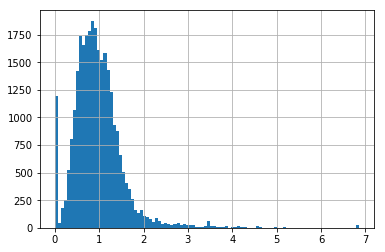

In [43]:
nodes['retail_lq'].hist(bins=100)

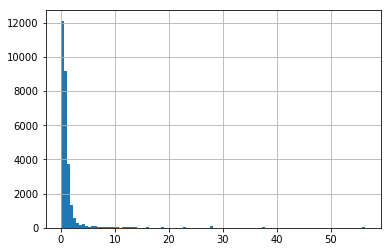

In [56]:
nodes['agr_wld_lq'].hist(bins=100)

### Plot

In [101]:
canvas = ds.Canvas(plot_width=400, plot_height=400,
                   x_range=(-123,-121.5), y_range=(37,38.5),
                   x_axis_type='linear', y_axis_type='linear')

agr,fire
mfg,retail

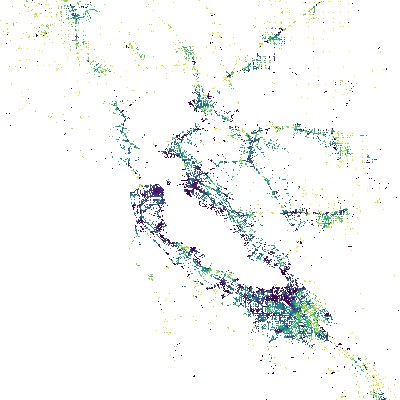
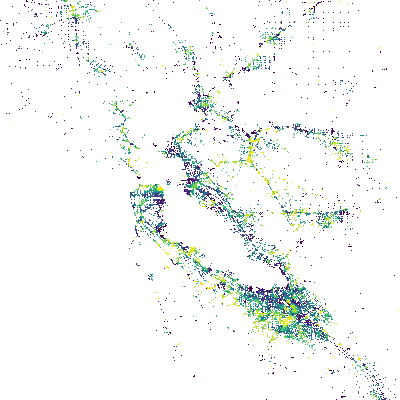
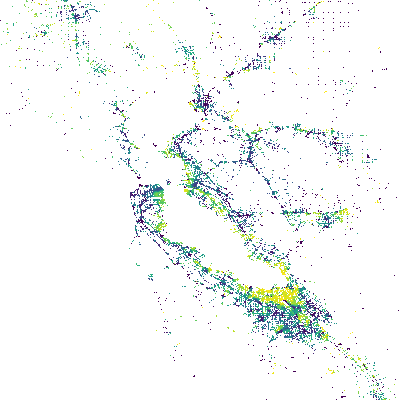
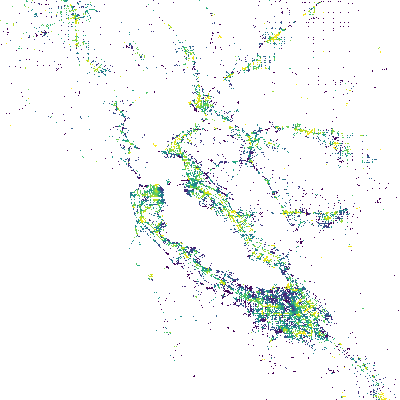

In [102]:
tf.Images(
    tf.shade(canvas.points(nodes,'x','y',ds.mean('agr_wld_lq')), cmap=ds.colors.viridis, name='agr'),
    tf.shade(canvas.points(nodes,'x','y',ds.mean('fire_lq')), cmap=ds.colors.viridis, name='fire'),
    tf.shade(canvas.points(nodes,'x','y',ds.mean('mfg_lq')), cmap=ds.colors.viridis, name='mfg'),
    tf.shade(canvas.points(nodes,'x','y',ds.mean('retail_lq')), cmap=ds.colors.viridis, name='retail')
).cols(2)

In [105]:
nodes.to_csv('../data/nodes_w_establishment_lq.csv')